In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import igraph as ig
import re
import warnings
from collections import Counter
from scipy.stats import mannwhitneyu
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import umap
import sklearn.datasets
import umap.plot

import collections

import scipy as sp
from scipy.linalg import block_diag
import numpy as np
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D  # noqa
import ot
warnings.filterwarnings("ignore")

/Users/yijwang-admin/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0. Parameters

In [2]:
# ROSMAP
ROSMAP_Exp_File = "../../../Data/ROSMAP_blood_gene_expression_monocyte_ACTL_04172023.csv"
ROSMAP_Clinical_File = "../../../Data/ROSMAP_blood_clinical_monocyte_ACTL_04172023.csv"

# ADNI
ADNI_Exp_File = "../../../Data/ADNI_blood_gene_expression_gene_aligned_04172023.csv"
ADNI_Clinical_File = "../../../Data/ADNI_blood_clinical_04172023.csv"
ADNI_LabelTransfer_File = "../../../Data/ADNI_Transfered_Label.csv"
ADNI_Longit_File = "../../../Data/ADNIMERGE.csv"

# A. Load data

## A1. Load Rosmap Blood data

In [3]:
# load data
# Blood ROSMAP
ROSMAPFrame = pd.read_csv(ROSMAP_Exp_File,header=0, index_col=0)
ROSMAPSampleID = list(ROSMAPFrame.columns.values)
ROSMAPGeneID = list(ROSMAPFrame.index.values)

# read in label
ROSMAP_Info = pd.read_csv(ROSMAP_Clinical_File,header=0, index_col=0)

In [4]:
ROSMAPFrame.head(2)

,Sample_003,Sample_004,Sample_014,Sample_021,Sample_031,Sample_037,Sample_040,Sample_050,Sample_057,Sample_058,...,Sample_563,Sample_572,Sample_573,Sample_578,Sample_580,Sample_581,Sample_582,Sample_588,Sample_590,Sample_608
A1BG,4.0,1,2,14.0,1.0,4.0,7,5.0,2,8,...,5.0,10.0,18,8,2,0,0.5,0,12.0,1.0
A2M,5.0,0,0,18.0,4.0,22.0,34,21.0,6,8,...,7.0,9.0,13,14,6,1,0.0,0,11.0,26.0


In [5]:
ROSMAP_Info.head(3)

,individualID,projid,msex,race,apoe_genotype,age_at_visit_max,age_death,cts_mmse30_lv,pmi,braaksc,ceradsc,cogdx,dcfdx_lv,Group1,Group2,specimenID
1,R1528689,402800,0,1,34.0,79.701574264202605,80.65708418891171,13.0,5.500000,5,1,4,4,Typical AD,Typical.AD,Sample_003
2,R3978789,482428,0,1,23.0,82.321697467488022,83.690622861054067,30.0,3.933333,4,4,1,1,Asym AD,Asym.AD,Sample_004
3,R5422277,3052480,0,1,23.0,90+,90+,15.0,10.583333,4,2,2,2,Asym AD,Asym.AD,Sample_014


### A1.1 Extract features

In [6]:
ROSMAP_SID = list(ROSMAP_Info.loc[:,'specimenID'])
ROSMAP_Class = list(ROSMAP_Info.loc[:,'Group1'])
ROSMAP_Sex = list(ROSMAP_Info.loc[:,'msex']) # 1->male 0->female reference: https://rpubs.com/tiagochst/AD_supplemental_ROSMAP_dataset
ROSMAP_Gender = list(ROSMAP_Info.loc[:,'msex']) # 1->male 0->female reference: https://rpubs.com/tiagochst/AD_supplemental_ROSMAP_dataset
ROSMAP_Age = list(ROSMAP_Info.loc[:,'age_at_visit_max'])
ROSMAP_braaksc = list(ROSMAP_Info.loc[:,'braaksc'])
ROSMAP_ceradsc = list(ROSMAP_Info.loc[:,'ceradsc'])
ROSMAP_cogdx = list(ROSMAP_Info.loc[:,'cogdx'])
ROSMAP_apeo_genotype = list(ROSMAP_Info.loc[:,'apoe_genotype'])
ROSMAP_cts_mmse30 = list(ROSMAP_Info.loc[:,'cts_mmse30_lv'])
ROSMAP_pmi = list(ROSMAP_Info.loc[:,'pmi'])
ROSMAP_dcfdx = list(ROSMAP_Info.loc[:,'dcfdx_lv'])

#print(ROSMAP_Gender)

# reomve characters in age
for i in range(len(ROSMAP_Age)):
    ROSMAP_Age[i] = round(float(re.findall(r"[-+]?(?:\d*\.*\d+)", ROSMAP_Age[i])[0]))
    ROSMAP_braaksc[i] = int(ROSMAP_braaksc[i])
    ROSMAP_ceradsc[i] = int(ROSMAP_ceradsc[i])
    ROSMAP_cogdx[i] = int(ROSMAP_cogdx[i])
    if ROSMAP_Gender[i] == 1:
        ROSMAP_Gender[i] = 'Male'
    else:
        ROSMAP_Gender[i] = 'Female'
#print(ROSMAP_Age)
#print(ROSMAP_Gender)


# dic for different feature
Mapping_ID_Class = dict(zip(ROSMAP_SID, ROSMAP_Class))
Mapping_ID_Class_ROSMAP = dict(zip(ROSMAP_SID, ROSMAP_Class))
Mapping_ID_Gender = dict(zip(ROSMAP_SID, ROSMAP_Gender))
Mapping_ID_Age = dict(zip(ROSMAP_SID, ROSMAP_Age))
Mapping_ID_braaksc = dict(zip(ROSMAP_SID, ROSMAP_braaksc))
Mapping_ID_ceradsc = dict(zip(ROSMAP_SID, ROSMAP_ceradsc))
Mapping_ID_cogdx = dict(zip(ROSMAP_SID, ROSMAP_cogdx))
Mapping_ID_apeo_genotype = dict(zip(ROSMAP_SID, ROSMAP_apeo_genotype))
Mapping_ID_cts_mmse30 = dict(zip(ROSMAP_SID, ROSMAP_cts_mmse30))
Mapping_ID_pmi = dict(zip(ROSMAP_SID, ROSMAP_pmi))
Mapping_ID_dcfdx = dict(zip(ROSMAP_SID, ROSMAP_dcfdx))
Mapping_ID_Sex = dict(zip(ROSMAP_SID, ROSMAP_Sex))


In [7]:
# Mapping from ROSMAPSampleID
ROSMAPSampleID_Class = list()
ROSMAPSampleID_Gender = list()
ROSMAPSampleID_Age = list()
ROSMAPSampleID_braaksc = list()
ROSMAPSampleID_ceradsc = list()
ROSMAPSampleID_cogdx = list()
ROSMAPSampleID_apeo_genotype = list()
ROSMAPSampleID_cts_mmse30 = list()
ROSMAPSampleID_pmi = list()
ROSMAPSampleID_dcfdx = list()
ROSMAPSampleID_Sex = list()

for idt in ROSMAPSampleID:
    ROSMAPSampleID_Class.append(Mapping_ID_Class[idt])
    ROSMAPSampleID_Gender.append(Mapping_ID_Gender[idt])
    ROSMAPSampleID_Age.append(Mapping_ID_Age[idt])
    ROSMAPSampleID_braaksc.append(Mapping_ID_braaksc[idt])
    ROSMAPSampleID_ceradsc.append(Mapping_ID_ceradsc[idt])
    ROSMAPSampleID_cogdx.append(Mapping_ID_cogdx[idt])
    ROSMAPSampleID_apeo_genotype.append(Mapping_ID_apeo_genotype[idt])
    ROSMAPSampleID_cts_mmse30.append(Mapping_ID_cts_mmse30[idt])
    ROSMAPSampleID_pmi.append(Mapping_ID_pmi[idt])
    ROSMAPSampleID_dcfdx.append(Mapping_ID_dcfdx[idt])
    ROSMAPSampleID_Sex.append(Mapping_ID_Sex[idt])
    

# Convert to anndata
anndata_ROSMAP = sc.AnnData(ROSMAPFrame.T)
anndata_ROSMAP.obs['Label']=ROSMAPSampleID_Class
anndata_ROSMAP.obs['Gender']=ROSMAPSampleID_Gender
anndata_ROSMAP.obs['Age']=ROSMAPSampleID_Age
anndata_ROSMAP.obs['braaksc']=ROSMAPSampleID_braaksc
anndata_ROSMAP.obs['ceradsc']=ROSMAPSampleID_ceradsc
anndata_ROSMAP.obs['cogdx']=ROSMAPSampleID_cogdx
anndata_ROSMAP.obs['apeo_genotype']=ROSMAPSampleID_apeo_genotype
anndata_ROSMAP.obs['cts_mmse30']=ROSMAPSampleID_cts_mmse30
anndata_ROSMAP.obs['pmi']=ROSMAPSampleID_pmi
anndata_ROSMAP.obs['dcfdx']=ROSMAPSampleID_dcfdx
anndata_ROSMAP.obs['Sex']=ROSMAPSampleID_Sex
anndata_ROSMAP.var['gene_short_name'] = ROSMAPGeneID
anndata_ROSMAP.X = anndata_ROSMAP.X.astype('float64') 


In [8]:
anndata_ROSMAP.obs.head(2)

,Label,Gender,Age,braaksc,ceradsc,cogdx,apeo_genotype,cts_mmse30,pmi,dcfdx,Sex
Sample_003,Typical AD,Female,80,5,1,4,34.0,13.0,5.500000,4,0
Sample_004,Asym AD,Female,82,4,4,1,23.0,30.0,3.933333,1,0


## A2. Load ADNI data

In [9]:
# load data
# Blood ROSMAP
ADNIFrame = pd.read_csv(ADNI_Exp_File,header=0, index_col=0)
ADNISampleID = list(ADNIFrame.columns.values)
ADNIGeneID = list(ADNIFrame.index.values)

# read in clinical
ADNI_Info = pd.read_csv(ADNI_Clinical_File,header=0, index_col=0)

# read in transferred label
ADNI_Label = pd.read_csv(ADNI_LabelTransfer_File,header=0, index_col=0)

# read in longitudinal data
# read in transferred label
ADNI_Log = pd.read_csv(ADNI_Longit_File,header=0, index_col=0)



In [10]:
ADNIFrame.head(2)

,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,036_S_4491,098_S_4059,...,082_S_4339,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101
A1BG,3.651,3.183,3.278,3.371,3.358,3.504,3.194,3.002,3.855,3.594,...,3.655,3.345,3.330,3.368,3.665,3.302,3.403,3.530,3.532,3.298
A2M,3.039,3.543,3.528,3.835,3.392,3.081,3.146,3.281,3.974,3.511,...,3.725,3.441,3.497,3.128,3.285,3.524,3.515,3.651,3.609,3.804


In [11]:
ADNI_Label.head(3)

,Label
Sample_ID,
116_S_1249,Asym AD
037_S_4410,Asym AD
006_S_4153,Asym AD


In [12]:
ADNI_Info

,X,PTID,max_follow_up_time,first_changing_time,Progressed,DX,DX_mutated,AGE,PTGENDER,VISCODE,M,EXAMDATE.bl,Years.bl,Month.bl,Month,Age_GE
1,1,002_S_2043,30.098361,30.098361,False,MCI,MCI,72.2,Female,bl,0,2010-09-07,0.000000,0.000000,0,72.200000
2,2,002_S_2073,72.065574,48.426230,True,MCI,CN,63.4,Female,bl,0,2010-09-21,0.000000,0.000000,0,63.400000
3,3,002_S_4171,30.032787,26.098361,True,MCI,Dementia,69.4,Male,bl,0,2011-08-25,0.000000,0.000000,0,69.400000
4,4,002_S_4213,96.163934,96.163934,False,CN,CN,78.0,Female,bl,0,2011-09-13,0.000000,0.000000,0,78.000000
5,5,002_S_4219,18.327869,18.327869,False,MCI,MCI,79.4,Female,bl,0,2011-09-27,0.000000,0.000000,0,79.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,740,068_S_0210,0.000000,0.000000,False,MCI,MCI,72.4,Female,m72,72,2006-02-23,6.075291,72.754098,72,78.475291
741,741,007_S_0101,16.295082,16.295082,False,Dementia,Dementia,73.6,Male,m72,72,2006-01-04,6.116359,73.245902,72,79.716359
742,742,003_S_0908,23.409836,23.409836,False,MCI,MCI,62.9,Female,m72,72,2006-10-12,6.283368,75.245902,78,69.183368
743,743,037_S_0501,14.295082,14.295082,True,MCI,Dementia,77.9,Male,m84,84,2006-06-23,6.830938,81.803279,84,84.730938


In [13]:
print(list(ADNI_Log.columns))

['COLPROT', 'ORIGPROT', 'PTID', 'SITE', 'VISCODE', 'EXAMDATE', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'FBB', 'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrailsB', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'DIGITSCOR_bl', 'TRABSCOR_bl', 'FAQ_bl', 'mPACCdigit_bl', 'mPA

In [14]:
ADNI_Log

,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
RID,,,,,,,,,,,,,,,,,,,,,
2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,16,...,NaN,1.25173,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-07-19 05:01:40.0
3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,18,...,22.83,1.22163,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-07-19 05:01:40.0
3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,18,...,22.83,1.22163,NaN,NaN,NaN,0.498289,5.96721,6,6,2022-07-19 05:01:40.0
3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,18,...,22.83,1.22163,NaN,NaN,NaN,0.999316,11.96720,12,12,2022-07-19 05:01:40.0
3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,18,...,22.83,1.22163,NaN,NaN,NaN,1.998630,23.93440,24,24,2022-07-19 05:01:40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6999,ADNI3,ADNI3,035_S_6999,35,m12,2022-09-14,SMC,70.0,Male,18,...,NaN,NaN,NaN,1.3235,NaN,0.980151,11.73770,12,12,2022-09-20 05:01:21.0
6570,ADNI3,ADNI3,941_S_6570,941,m48,2022-09-20,CN,71.2,Male,18,...,NaN,NaN,NaN,NaN,1.0253,4.027380,48.22950,48,48,2022-09-21 04:59:38.0
5214,ADNI3,ADNI2,126_S_5214,126,m108,2022-09-20,SMC,69.6,Female,12,...,14.56,1.36993,NaN,1.0208,NaN,9.196440,110.13100,108,108,2022-09-22 04:58:51.0


### A2.1 Extract features

In [15]:
# extract data and covert nan to 0
def Extract_Feature_BL(DF, Feature):
    SID = list(DF.loc[:, 'PTID'])
    SID = list(set(SID))
    
    NumNan = 0
    Vlist = list()
    for i in range(len(SID)):
        sid = SID[i]
        DF_tmp = DF.loc[DF['PTID'] == sid]
        vtmp = DF_tmp[Feature].values[0]
        if str(vtmp) == 'nan' or str(vtmp) == 'NaN':
            NumNan = NumNan + 1
            vtmp = np.inf
        if '>' in str(vtmp) or '<' in str(vtmp):
            vtmp = str(vtmp)[1:]
        Vlist.append(float(vtmp))
    Vlist = np.array(Vlist)
    Mapping = dict(zip(SID, Vlist))
    
    return Mapping, NumNan
    

In [16]:
Mapping_MMSE_BL, NumN = Extract_Feature_BL(ADNI_Log, 'MMSE_bl')
print("MMSE_BL has ", NumN, " nans")
Mapping_CDRSB_BL, NumN = Extract_Feature_BL(ADNI_Log, 'CDRSB_bl')
print("CDRSB_BL has ", NumN, " nans")

Mapping_Tau_BL, NumN = Extract_Feature_BL(ADNI_Log, 'TAU_bl')
print("TAU_BL has ", NumN, " nans")
Mapping_PTau_BL, NumN = Extract_Feature_BL(ADNI_Log, 'PTAU_bl')
print("PTAU_BL has ", NumN, " nans")
Mapping_AV45_BL, NumN = Extract_Feature_BL(ADNI_Log, 'AV45_bl')
print("AV45_BL has ", NumN, " nans")



MMSE_BL has  1  nans
CDRSB_BL has  0  nans
TAU_BL has  1206  nans
PTAU_BL has  1206  nans
AV45_BL has  1288  nans


In [17]:
# Get CDRSB based on Month
ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Month = np.zeros(len(ADNI_SID))
Feature  = 'CDRSB' 

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i], ExpTime[i])
    if ExpTime[i] == 0:
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == 'bl']
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = float(ADNI_Log_tmp2[Feature].values[0])
    else:
        StrTime = 'm'+str(ExpTime[i])
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == StrTime]
        if len(ADNI_Log_tmp2[Feature])==0:
            PTau_Month[i] = np.inf
            continue
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = ADNI_Log_tmp2[Feature].values[0]
    #print(PTau_Month[i])

Mapping_ID_CDRSB_Month = dict(zip(ADNI_SID, PTau_Month))

In [18]:
# Get MMSE based on Month
ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Month = np.zeros(len(ADNI_SID))
Feature  = 'MMSE' 

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i], ExpTime[i])
    if ExpTime[i] == 0:
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == 'bl']
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = float(ADNI_Log_tmp2[Feature].values[0])
    else:
        StrTime = 'm'+str(ExpTime[i])
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == StrTime]
        if len(ADNI_Log_tmp2[Feature])==0:
            PTau_Month[i] = np.inf
            continue
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = ADNI_Log_tmp2[Feature].values[0]
    #print(PTau_Month[i])

Mapping_ID_MMSE_Month = dict(zip(ADNI_SID, PTau_Month))

In [19]:
# Get MMSE based on Month
ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Month = np.zeros(len(ADNI_SID))
Feature  = 'PTAU' 

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i], ExpTime[i])
    if ExpTime[i] == 0:
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == 'bl']
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = float(ADNI_Log_tmp2[Feature].values[0])
    else:
        StrTime = 'm'+str(ExpTime[i])
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == StrTime]
        if len(ADNI_Log_tmp2[Feature])==0:
            PTau_Month[i] = np.inf
            continue
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = ADNI_Log_tmp2[Feature].values[0]
    #print(PTau_Month[i])

Mapping_ID_PTau_Month = dict(zip(ADNI_SID, PTau_Month))

In [20]:
# Get MMSE based on Month
ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Month = np.zeros(len(ADNI_SID))
Feature  = 'AV45' 

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i], ExpTime[i])
    if ExpTime[i] == 0:
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == 'bl']
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = float(ADNI_Log_tmp2[Feature].values[0])
    else:
        StrTime = 'm'+str(ExpTime[i])
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == StrTime]
        if len(ADNI_Log_tmp2[Feature])==0:
            PTau_Month[i] = np.inf
            continue
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = ADNI_Log_tmp2[Feature].values[0]
    #print(PTau_Month[i])

Mapping_ID_AV45_Month = dict(zip(ADNI_SID, PTau_Month))

In [21]:
# Get MMSE based on Month
ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Month = np.zeros(len(ADNI_SID))
Feature  = 'TAU' 

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i], ExpTime[i])
    if ExpTime[i] == 0:
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == 'bl']
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = float(ADNI_Log_tmp2[Feature].values[0])
    else:
        StrTime = 'm'+str(ExpTime[i])
        ADNI_Log_tmp2 = ADNI_Log_tmp.loc[ADNI_Log_tmp['VISCODE'] == StrTime]
        if len(ADNI_Log_tmp2[Feature])==0:
            PTau_Month[i] = np.inf
            continue
        if str(ADNI_Log_tmp2[Feature].values[0]) == 'nan':
            PTau_Month[i] = np.inf
        elif str(ADNI_Log_tmp2[Feature].values[0]) == '<8':
            PTau_Month[i] = 8.0
        else:
            PTau_Month[i] = ADNI_Log_tmp2[Feature].values[0]
    #print(PTau_Month[i])

Mapping_ID_Tau_Month = dict(zip(ADNI_SID, PTau_Month))

In [22]:
# Get PTAU based on close to Month
def VISCODE_TO_Number(StrList):
    Month_Digit = np.zeros(len(StrList))
    for i in range(len(StrList)):
        #print(StrList[i])
        if StrList[i] == 'bl':
            Month_Digit[i] = 0
        else:
            Month_Digit[i] = int(StrList[i][1:])
    return Month_Digit
        
Feature = "MMSE"

ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Close = np.zeros(len(ADNI_SID))

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i])
    
    tmp = list(ADNI_Log_tmp[Feature])
    tmp_viscode = list(ADNI_Log_tmp['VISCODE'])
    indt = list()
    ptau = list()
    for j in range(len(tmp)):
        if str(tmp[j]) != 'nan':
            #print(tmp[j])
            stmp = re.findall(r"[-+]?(?:\d*\.*\d+)", str(tmp[j]))
            indt.append(tmp_viscode[j])
            ptau.append(float(stmp[0]))
    #print(indt)
    #print(ptau)
    Month = VISCODE_TO_Number(indt)
    
    if len(indt) == 0:
        PTau_Close[i] = np.inf
        continue
    
    Month_Dis = np.abs(np.array(Month - ExpTime[i]))
    MaxId = np.argmin(Month_Dis)
    
    #print(ExpTime[i], ptau[MaxId])
    PTau_Close[i] = ptau[MaxId]
    
    #ADNI_log_T = ADNI_Log_tmp.loc[~np.isnan(NumArr)]
    #Time_tmp = list(ADNI_log_T['VISCODE'])
    
Mapping_ID_MMSE_Close = dict(zip(ADNI_SID, PTau_Close))

In [23]:
# Get PTAU based on close to Month
def VISCODE_TO_Number(StrList):
    Month_Digit = np.zeros(len(StrList))
    for i in range(len(StrList)):
        #print(StrList[i])
        if StrList[i] == 'bl':
            Month_Digit[i] = 0
        else:
            Month_Digit[i] = int(StrList[i][1:])
    return Month_Digit
        
Feature = "TAU"

ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Close = np.zeros(len(ADNI_SID))

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i])
    
    tmp = list(ADNI_Log_tmp[Feature])
    tmp_viscode = list(ADNI_Log_tmp['VISCODE'])
    indt = list()
    ptau = list()
    for j in range(len(tmp)):
        if str(tmp[j]) != 'nan':
            #print(tmp[j])
            stmp = re.findall(r"[-+]?(?:\d*\.*\d+)", str(tmp[j]))
            indt.append(tmp_viscode[j])
            ptau.append(float(stmp[0]))
    #print(indt)
    #print(ptau)
    Month = VISCODE_TO_Number(indt)
    
    if len(indt) == 0:
        PTau_Close[i] = np.inf
        continue
    
    Month_Dis = np.abs(np.array(Month - ExpTime[i]))
    MaxId = np.argmin(Month_Dis)
    
    #print(ExpTime[i], ptau[MaxId])
    PTau_Close[i] = ptau[MaxId]
    
    #ADNI_log_T = ADNI_Log_tmp.loc[~np.isnan(NumArr)]
    #Time_tmp = list(ADNI_log_T['VISCODE'])
    
Mapping_ID_TAU_Close = dict(zip(ADNI_SID, PTau_Close))

In [24]:
# Get PTAU based on close to Month
def VISCODE_TO_Number(StrList):
    Month_Digit = np.zeros(len(StrList))
    for i in range(len(StrList)):
        #print(StrList[i])
        if StrList[i] == 'bl':
            Month_Digit[i] = 0
        else:
            Month_Digit[i] = int(StrList[i][1:])
    return Month_Digit
        
Feature = "AV45"

ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Close = np.zeros(len(ADNI_SID))

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i])
    
    tmp = list(ADNI_Log_tmp[Feature])
    tmp_viscode = list(ADNI_Log_tmp['VISCODE'])
    indt = list()
    ptau = list()
    for j in range(len(tmp)):
        if str(tmp[j]) != 'nan':
            #print(tmp[j])
            stmp = re.findall(r"[-+]?(?:\d*\.*\d+)", str(tmp[j]))
            indt.append(tmp_viscode[j])
            ptau.append(float(stmp[0]))
    #print(indt)
    #print(ptau)
    Month = VISCODE_TO_Number(indt)
    
    if len(indt) == 0:
        PTau_Close[i] = np.inf
        continue
    
    Month_Dis = np.abs(np.array(Month - ExpTime[i]))
    MaxId = np.argmin(Month_Dis)
    
    #print(ExpTime[i], ptau[MaxId])
    PTau_Close[i] = ptau[MaxId]
    
    #ADNI_log_T = ADNI_Log_tmp.loc[~np.isnan(NumArr)]
    #Time_tmp = list(ADNI_log_T['VISCODE'])
    
Mapping_ID_AV45_Close = dict(zip(ADNI_SID, PTau_Close))

In [25]:
# Get PTAU based on close to Month

def VISCODE_TO_Number(StrList):
    Month_Digit = np.zeros(len(StrList))
    for i in range(len(StrList)):
        #print(StrList[i])
        if StrList[i] == 'bl':
            Month_Digit[i] = 0
        else:
            Month_Digit[i] = int(StrList[i][1:])
    return Month_Digit
        

ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ExpTime = ADNI_Info.Month.values
PTau_Close = np.zeros(len(ADNI_SID))

for i in range(len(ADNI_SID)):
    ADNI_Log_tmp = ADNI_Log.loc[ADNI_Log['PTID'] == ADNI_SID[i]]
    #print(ADNI_SID[i])
    
    tmp = list(ADNI_Log_tmp['PTAU'])
    tmp_viscode = list(ADNI_Log_tmp['VISCODE'])
    indt = list()
    ptau = list()
    for j in range(len(tmp)):
        if str(tmp[j]) != 'nan':
            #print(tmp[j])
            stmp = re.findall(r"[-+]?(?:\d*\.*\d+)", str(tmp[j]))
            indt.append(tmp_viscode[j])
            ptau.append(float(stmp[0]))
    #print(indt)
    #print(ptau)
    Month = VISCODE_TO_Number(indt)
    
    if len(indt) == 0:
        PTau_Close[i] = np.inf
        continue
    
    Month_Dis = np.abs(np.array(Month - ExpTime[i]))
    MaxId = np.argmin(Month_Dis)
    
    #print(ExpTime[i], ptau[MaxId])
    PTau_Close[i] = ptau[MaxId]
    
    #ADNI_log_T = ADNI_Log_tmp.loc[~np.isnan(NumArr)]
    #Time_tmp = list(ADNI_log_T['VISCODE'])
    
Mapping_ID_PTau_Close = dict(zip(ADNI_SID, PTau_Close))

In [26]:
#Mapping_ID_PTau_Close

In [27]:

ADNI_SID2 = list(ADNI_Label.index.values)
ADNI_Class = list(ADNI_Label.loc[:,'Label'])

ADNI_SID = list(ADNI_Info.loc[:,'PTID'])
ADNI_Gender = list(ADNI_Info.loc[:,'PTGENDER']) 
ADNI_Age = list(ADNI_Info.loc[:,'Age_GE'])
ADNI_DX = list(ADNI_Info.loc[:,'DX'])
ADNI_Progressed = list(ADNI_Info.loc[:,'Progressed'])
ADNI_first_changing_time = list(ADNI_Info.loc[:,'first_changing_time'])

# data cleaning
for i in range(len(ADNI_Age)):
    ADNI_Age[i] = round(float(ADNI_Age[i]))
    if ADNI_Progressed[i] == True:
        ADNI_Progressed[i] = 'Yes'
    else:
        ADNI_Progressed[i] = 'No'
#print(ADNI_Age)
#print(ADNI_Gender)
#print(ADNI_Progressed)

# dic for different feature
Mapping_ID_Class = dict(zip(ADNI_SID2, ADNI_Class))
Mapping_ID_Gender = dict(zip(ADNI_SID, ADNI_Gender))
Mapping_ID_Age = dict(zip(ADNI_SID, ADNI_Age))
Mapping_ID_DX = dict(zip(ADNI_SID, ADNI_DX))
Mapping_ID_Progressed = dict(zip(ADNI_SID, ADNI_Progressed))
Mapping_ID_first_changing_time = dict(zip(ADNI_SID, ADNI_first_changing_time))

In [28]:
# Mapping from ADNISampleID
ADNISampleID_Class = list()
ADNISampleID_Gender = list()
ADNISampleID_Age = list()
ADNISampleID_DX = list()
ADNISampleID_Progressed = list()

ADNISampleID_MMSE_BL = list()
ADNISampleID_CDRSB_BL = list()
ADNISampleID_MMSE_Close = list()

ADNISampleID_CDRSB_Month = list()
ADNISampleID_MMSE_Month = list()

ADNISampleID_PTau_Close = list()
ADNISampleID_Tau_Close = list()
ADNISampleID_AV45_Close = list()

ADNISampleID_PTau_Month = list()
ADNISampleID_Tau_Month = list()
ADNISampleID_AV45_Month = list()

ADNISampleID_PTau_BL = list()
ADNISampleID_Tau_BL = list()
ADNISampleID_AV45_BL = list()


ADNISampleID_first_changing_time = list()
for idt in ADNISampleID:
    ADNISampleID_Class.append(Mapping_ID_Class[idt])
    ADNISampleID_Gender.append(Mapping_ID_Gender[idt])
    ADNISampleID_Age.append(Mapping_ID_Age[idt])
    ADNISampleID_DX.append(Mapping_ID_DX[idt])
    ADNISampleID_Progressed.append(Mapping_ID_Progressed[idt])
    ADNISampleID_first_changing_time.append(Mapping_ID_first_changing_time[idt])

    ADNISampleID_MMSE_Month.append(Mapping_ID_MMSE_Month[idt])
    ADNISampleID_MMSE_Close.append(Mapping_ID_MMSE_Close[idt])
  
    ADNISampleID_MMSE_BL.append(Mapping_MMSE_BL[idt])
    ADNISampleID_CDRSB_BL.append(Mapping_CDRSB_BL[idt])
    
    ADNISampleID_PTau_Close.append(Mapping_ID_PTau_Close[idt])
    ADNISampleID_Tau_Close.append(Mapping_ID_TAU_Close[idt])
    ADNISampleID_AV45_Close.append(Mapping_ID_AV45_Close[idt])
    
    ADNISampleID_PTau_Month.append(Mapping_ID_PTau_Month[idt])
    ADNISampleID_Tau_Month.append(Mapping_ID_Tau_Month[idt])
    ADNISampleID_AV45_Month.append(Mapping_ID_AV45_Month[idt])
    
    ADNISampleID_PTau_BL.append(Mapping_PTau_BL[idt])
    ADNISampleID_Tau_BL.append(Mapping_Tau_BL[idt])
    ADNISampleID_AV45_BL.append(Mapping_AV45_BL[idt])
    
    ADNISampleID_CDRSB_Month.append(Mapping_ID_CDRSB_Month[idt])

    
    

# Convert to anndata
anndata_ADNI = sc.AnnData(ADNIFrame.T)
anndata_ADNI.obs['Label']=ADNISampleID_Class
anndata_ADNI.obs['Gender']=ADNISampleID_Gender
anndata_ADNI.obs['Age']=ADNISampleID_Age
anndata_ADNI.obs['DX']=ADNISampleID_DX
anndata_ADNI.obs['Progressed']=ADNISampleID_Progressed

anndata_ADNI.obs['MMSE_Month']=ADNISampleID_MMSE_Month
anndata_ADNI.obs['MMSE_Close']=ADNISampleID_MMSE_Close

anndata_ADNI.obs['MMSE_BL']=ADNISampleID_MMSE_BL
anndata_ADNI.obs['CDRSB_BL']=ADNISampleID_CDRSB_BL

anndata_ADNI.obs['PTAU_Close']=ADNISampleID_PTau_Close
anndata_ADNI.obs['TAU_Close']=ADNISampleID_Tau_Close
anndata_ADNI.obs['AV45_Close']=ADNISampleID_AV45_Close

anndata_ADNI.obs['PTAU_Month']=ADNISampleID_PTau_Month
anndata_ADNI.obs['TAU_Month']=ADNISampleID_Tau_Month
anndata_ADNI.obs['AV45_Month']=ADNISampleID_AV45_Month

anndata_ADNI.obs['PTAU_BL']=ADNISampleID_PTau_BL
anndata_ADNI.obs['TAU_BL']=ADNISampleID_Tau_BL
anndata_ADNI.obs['AV45_BL']=ADNISampleID_AV45_BL

anndata_ADNI.obs['CDRSB_Month']=ADNISampleID_CDRSB_Month


anndata_ADNI.obs['first_changing_time']=ADNISampleID_first_changing_time
anndata_ADNI.var['gene_short_name'] = ADNIGeneID
anndata_ADNI.X = anndata_ADNI.X.astype('float64') 

In [29]:
anndata_ADNI.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,TAU_Close,AV45_Close,PTAU_Month,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,0.0,35.836066
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,313.5,0.9862,29.14,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,405.9,1.2779,42.01,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,inf,1.2821,inf,inf,1.2821,inf,inf,inf,0.0,36.295082
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,281.8,1.3392,27.46,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,576.9,1.3430,57.70,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,285.2,1.3257,26.26,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,166.1,0.9873,14.10,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,313.2,1.6553,30.92,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262


# B. Data nomrlization

In [30]:
anndata_ROSMAP

AnnData object with n_obs × n_vars = 157 × 7704
    obs: 'Label', 'Gender', 'Age', 'braaksc', 'ceradsc', 'cogdx', 'apeo_genotype', 'cts_mmse30', 'pmi', 'dcfdx', 'Sex'
    var: 'gene_short_name'

In [31]:
anndata_ADNI

AnnData object with n_obs × n_vars = 744 × 7704
    obs: 'Label', 'Gender', 'Age', 'DX', 'Progressed', 'MMSE_Month', 'MMSE_Close', 'MMSE_BL', 'CDRSB_BL', 'PTAU_Close', 'TAU_Close', 'AV45_Close', 'PTAU_Month', 'TAU_Month', 'AV45_Month', 'PTAU_BL', 'TAU_BL', 'AV45_BL', 'CDRSB_Month', 'first_changing_time'
    var: 'gene_short_name'

In [32]:
# pick only top 5000 highly variable genes
Ntop = 7000
sc.pp.recipe_zheng17(anndata_ROSMAP, n_top_genes=Ntop)
sc.pp.recipe_zheng17(anndata_ADNI, n_top_genes=Ntop, log=False)


In [33]:
TopGeneROSMAP = list(anndata_ROSMAP.var.index)
TOpGeneADNI = list(anndata_ADNI.var.index)

TopGeneOverlap = list(set(TopGeneROSMAP) & set(TOpGeneADNI))

print("The overlaps of highly variable genes are ", len(TopGeneOverlap))

The overlaps of highly variable genes are  6351


In [34]:
anndata_ROSMAP_Top = anndata_ROSMAP[:,TopGeneOverlap]
anndata_ADNI_Top = anndata_ADNI[:,TopGeneOverlap]


# C. OPT

In [35]:
M = ot.dist(np.array(anndata_ROSMAP_Top.X), np.array(anndata_ADNI_Top.X), metric='sqeuclidean')  #correlation
M /= M.max()

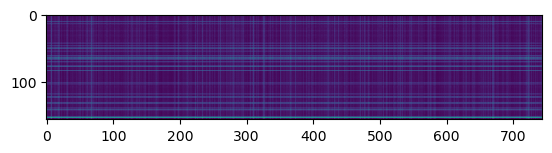

In [36]:
pl.imshow(M)


In [37]:
a = ot.unif(M.shape[0])
b = ot.unif(M.shape[1])

In [38]:
#Solve EMD with entropic regularization
def f(G):
    return np.sum(G * np.log(G))


def df(G):
    return np.log(G) + 1.


reg = 1e-3

Ge = ot.optim.cg(a, b, M, reg, f, df, verbose=True)

#pl.figure(3, figsize=(5, 5))
#ot.plot.plot1D_mat(a, b, Ge, 'OT matrix Entrop. reg')


It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.160208e-01|0.000000e+00|0.000000e+00
    1|1.070096e-01|8.420941e-02|9.011214e-03
    2|1.066143e-01|3.707745e-03|3.952986e-04
    3|1.065586e-01|5.224746e-04|5.567417e-05
    4|1.064237e-01|1.267794e-03|1.349234e-04
    5|1.063558e-01|6.379393e-04|6.784857e-05
    6|1.063280e-01|2.615442e-04|2.780948e-05
    7|1.062807e-01|4.457716e-04|4.737690e-05
    8|1.062532e-01|2.582833e-04|2.744343e-05
    9|1.062372e-01|1.504157e-04|1.597975e-05
   10|1.062330e-01|4.026892e-05|4.277886e-06
   11|1.062106e-01|2.104299e-04|2.234988e-05
   12|1.061937e-01|1.593742e-04|1.692454e-05
   13|1.061808e-01|1.209198e-04|1.283937e-05
   14|1.061718e-01|8.490031e-05|9.014021e-06
   15|1.061656e-01|5.827605e-05|6.186914e-06
   16|1.061622e-01|3.231073e-05|3.430178e-06
   17|1.061619e-01|2.613374e-06|2.774408e-07
   18|1.061534e-01|7.998329e-05|8.490501e-06
   19|1.061456e-01|7.353319e-05|7.805227e-06
It. 

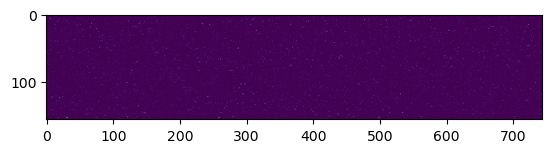

In [39]:
pl.imshow(Ge)


# D. Analyze the results

## D.1 brak score transfer

In [40]:
Pe = Ge/Ge.sum(axis=1,keepdims=1)

In [41]:
ROSMAP_New = Pe @ anndata_ADNI_Top.X

<Axes: >

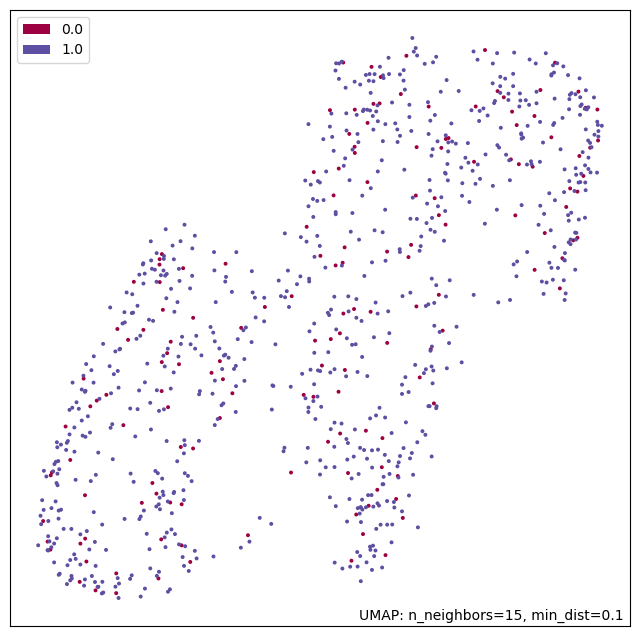

In [42]:
# Umap need a matrix obs by features
Embed_Stack = np.vstack((ROSMAP_New,anndata_ADNI_Top.X))

# label
N_K1 = np.shape(ROSMAP_New)[0]
Label = np.zeros(np.shape(Embed_Stack)[0])
Label[N_K1:] = 1

mapper = umap.UMAP().fit(Embed_Stack)

umap.plot.points(mapper, labels=Label)

In [43]:
anndata_ROSMAP_Top.layers["OPT_Em"] =  ROSMAP_New

In [44]:
np.array(anndata_ROSMAP_Top.obs['braaksc'])

array([5, 4, 4, 2, 5, 4, 4, 2, 4, 5, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5,
       4, 4, 1, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 4, 4, 1, 4, 5, 4, 5, 5, 4,
       4, 5, 5, 4, 5, 4, 4, 5, 0, 4, 4, 4, 5, 4, 4, 5, 4, 4, 4, 4, 5, 5,
       4, 5, 5, 4, 5, 4, 4, 4, 4, 4, 4, 2, 4, 5, 5, 4, 4, 4, 5, 1, 1, 5,
       4, 4, 5, 5, 5, 4, 0, 5, 2, 5, 4, 1, 4, 5, 2, 5, 2, 2, 4, 4, 4, 5,
       1, 2, 1, 4, 4, 2, 6, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5, 6, 4, 2,
       5, 5, 5, 4, 5, 5, 4, 5, 4, 4, 0, 0, 5, 4, 5, 4, 4, 1, 5, 5, 5, 4,
       1, 5, 4])

In [45]:
# bakk score transfer

from sklearn.neighbors import KNeighborsClassifier

ROSMAP_new_ = ROSMAP_New
Bakk = np.array(anndata_ROSMAP_Top.obs['braaksc'])
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(ROSMAP_new_,Bakk)

KNeighborsClassifier(n_neighbors=1)

In [46]:
bakk_trans = np.zeros(anndata_ADNI_Top.shape[0])
bakk_trans = -1+bakk_trans

for i in range(anndata_ADNI_Top.shape[0]):
    bakk_trans[i] = neigh.predict([anndata_ADNI_Top.X[i,:]])

In [47]:
counter = collections.Counter(bakk_trans)
print(counter)

Counter({4.0: 362, 5.0: 252, 1.0: 51, 2.0: 36, 0.0: 27, 6.0: 16})


In [48]:
anndata_ADNI_Top.obs['braaksc_trans'] = bakk_trans

In [49]:
anndata_ADNI_Top.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,PTAU_Month,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,...,inf,inf,inf,inf,inf,inf,0.0,35.836066,46323.804849,5.0
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,29.14,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,42.01,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,...,inf,inf,1.2821,inf,inf,inf,0.0,36.295082,45672.591813,4.0
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,27.46,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,57.70,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,26.26,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,14.10,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,...,30.92,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262,45695.602901,1.0


In [50]:
tt = list(anndata_ADNI_Top.obs.CDRSB_Month)
counter = collections.Counter(tt)
print(counter)

Counter({0.0: 213, 0.5: 104, 1.0: 95, 1.5: 64, inf: 50, 2.0: 48, 2.5: 42, 3.5: 19, 3.0: 16, 4.0: 14, 5.0: 14, 4.5: 13, 6.0: 13, 10.0: 9, 7.0: 8, 5.5: 6, 8.0: 5, 9.0: 4, 11.0: 2, 12.0: 2, 17.0: 1, 6.5: 1, 15.0: 1})


## D.2 Classfy ADNI sampel based on brak score and crd score (Metrie I)

In [51]:
Label = list()
SID = list(anndata_ADNI_Top.obs.index)

for gt in SID:
    CRD = anndata_ADNI_Top.obs.loc[gt,:].CDRSB_Month
    Braak = anndata_ADNI_Top.obs.loc[gt,:].braaksc_trans
    Dx = anndata_ADNI_Top.obs.loc[gt,:].DX
    if CRD > 4 and Braak >=4:
        Label.append("Typical AD")
    elif CRD <= 4 and Braak >=4 and CRD > 0:
        Label.append("Asym AD")
    elif CRD > 4 and Braak <=2:
        Label.append("Low-NFT AD")
    elif CRD <= 0.5 and Braak <=2:
        Label.append("Control")
    else:
        Label.append("Others")
                                   

In [52]:
anndata_ADNI_Top.obs['NewLabel'] = Label

<Axes: xlabel='NewLabel', ylabel='MMSE_Month'>

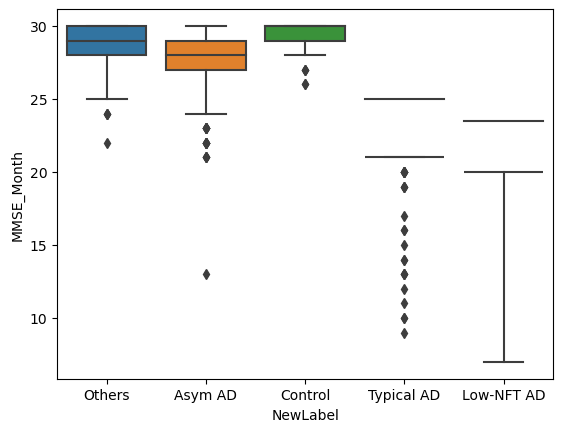

In [53]:
sns.boxplot(data=anndata_ADNI_Top.obs, x='NewLabel', y='MMSE_Month')

<Axes: xlabel='NewLabel', ylabel='MMSE_Close'>

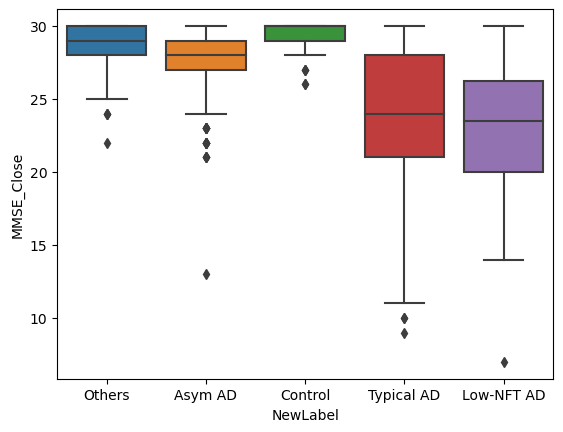

In [54]:
sns.boxplot(data=anndata_ADNI_Top.obs, x='NewLabel', y='MMSE_Close')

In [55]:
counter = collections.Counter(Label)
print(counter)

Counter({'Asym AD': 341, 'Others': 227, 'Typical AD': 109, 'Control': 47, 'Low-NFT AD': 20})


# E. Evaulation

In [56]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel=='Asym AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_Asym = (counter['CN'] + counter['MCI']) / df.shape[0]
print("Asym AD transfer accuracy is ", Acc_Asym)

Counter({'MCI': 297, 'Dementia': 29, 'CN': 15})
Asym AD transfer accuracy is  0.9149560117302052


In [57]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel=='Typical AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_TAD = (counter['Dementia'] + counter['MCI']) / df.shape[0]
print("Typical AD transfer accuracy is ", Acc_TAD)

Counter({'Dementia': 70, 'MCI': 24, 'CN': 15})
Typical AD transfer accuracy is  0.8623853211009175


In [58]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel=='Low-NFT AD']
counter = collections.Counter(df['DX'])
print(counter)
Acc_LTau = (counter['Dementia'] + counter['MCI']) / df.shape[0]
print("Low-NFT AD transfer accuracy is ", Acc_LTau)

Counter({'Dementia': 14, 'MCI': 4, 'CN': 2})
Low-NFT AD transfer accuracy is  0.9


In [59]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel=='Control']
counter = collections.Counter(df['DX'])
print(counter)
Acc_CN = (counter['CN']) / df.shape[0]
print("Control transfer accuracy is ", Acc_CN)

Counter({'CN': 35, 'MCI': 12})
Control transfer accuracy is  0.7446808510638298


In [60]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel=='Others']
counter = collections.Counter(df['DX'])
print(counter)

Counter({'CN': 179, 'MCI': 45, 'Dementia': 3})


In [61]:
Acc_Avg = (Acc_Asym + Acc_CN + Acc_LTau + Acc_TAD)/4
print("Avg acc is ", Acc_Avg)

Avg acc is  0.8555055459737382


In [62]:
anndata_ADNI_Top.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,...,inf,inf,inf,inf,inf,0.0,35.836066,46323.804849,5.0,Others
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0,Others
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0,Asym AD
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,...,inf,1.2821,inf,inf,inf,0.0,36.295082,45672.591813,4.0,Others
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0,Asym AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0,Others
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0,Asym AD
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0,Asym AD
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,...,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262,45695.602901,1.0,Control


# F Classfy ADNI sampel based on brak score and crd score (Metrie II)

In [63]:
anndata_ADNI_Top.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,...,inf,inf,inf,inf,inf,0.0,35.836066,46323.804849,5.0,Others
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0,Others
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0,Asym AD
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,...,inf,1.2821,inf,inf,inf,0.0,36.295082,45672.591813,4.0,Others
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0,Asym AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0,Others
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0,Asym AD
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0,Asym AD
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,...,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262,45695.602901,1.0,Control


In [64]:
Label = list()

for gt in SID:
    CRD = anndata_ADNI_Top.obs.loc[gt,:].CDRSB_Month
    Braak = anndata_ADNI_Top.obs.loc[gt,:].braaksc_trans
    MMSE = anndata_ADNI_Top.obs.loc[gt,:].MMSE_Month
    Dx = anndata_ADNI_Top.obs.loc[gt,:].DX
    if CRD > 4 and Braak >=4 and Dx == 'Dementia':
        Label.append("Typical AD")
    elif CRD <= 4 and Braak >=4 and CRD > 0:
        Label.append("Asym AD")
    elif CRD > 4 and Braak <=2:
        Label.append("Low-NFT AD")
    elif CRD == 0 and Braak <=2 and Dx == 'CN':
        Label.append("Control")
    else:
        Label.append("Others")
                                   

In [65]:
anndata_ADNI_Top.obs['NewLabel'] = Label

In [66]:
anndata_ADNI_Top.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,...,inf,inf,inf,inf,inf,0.0,35.836066,46323.804849,5.0,Others
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0,Others
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0,Asym AD
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,...,inf,1.2821,inf,inf,inf,0.0,36.295082,45672.591813,4.0,Others
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0,Asym AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0,Others
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0,Asym AD
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0,Asym AD
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,...,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262,45695.602901,1.0,Control


In [67]:
#df = anndata_ADNI_Top.obs

In [68]:
#df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

<Axes: xlabel='NewLabel', ylabel='MMSE_Month'>

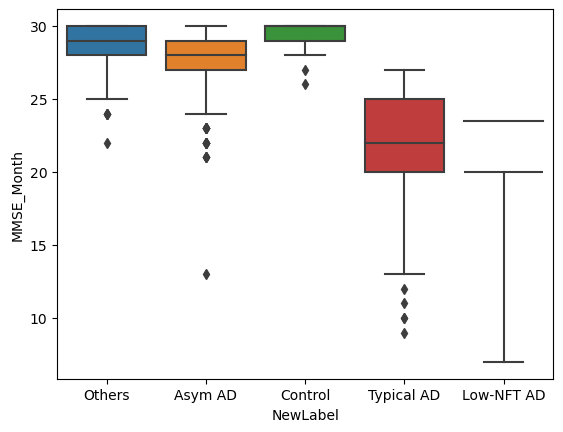

In [69]:
sns.boxplot(data=anndata_ADNI_Top.obs, x='NewLabel', y='MMSE_Month')

<Axes: xlabel='NewLabel', ylabel='MMSE_Close'>

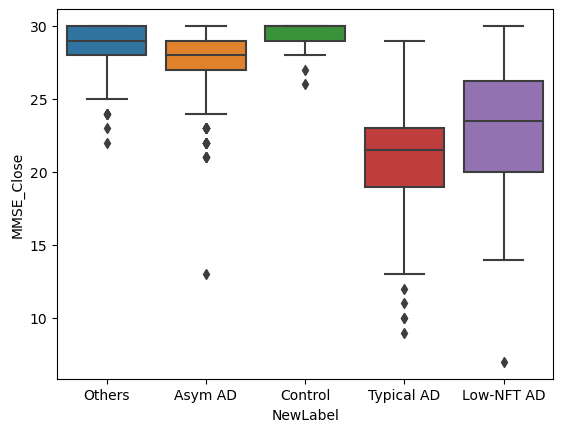

In [70]:
sns.boxplot(data=anndata_ADNI_Top.obs, x='NewLabel', y='MMSE_Close')

In [71]:
counter = collections.Counter(Label)
print(counter)

Counter({'Asym AD': 341, 'Others': 281, 'Typical AD': 70, 'Control': 32, 'Low-NFT AD': 20})


In [72]:
anndata_ADNI_Top.obs.to_csv("../../../Data/ADNI_OPT_Transfer_NewLabel_Clinical_Info.csv")

In [500]:
anndata_ADNI_Top.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,...,inf,inf,inf,inf,inf,0.0,35.836066,46323.804849,5.0,Others
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0,Others
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0,Asym AD
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,...,inf,1.2821,inf,inf,inf,0.0,36.295082,45672.591813,4.0,Others
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0,Asym AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0,Others
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0,Asym AD
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0,Asym AD
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,...,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262,45695.602901,1.0,Control


In [501]:
anndata_ADNI_obs_dropna = anndata_ADNI_Top.obs.replace(np.inf, np.nan).dropna() 

In [507]:
anndata_ADNI_obs_dropna

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0,Others
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0,Asym AD
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0,Asym AD
007_S_4467,Asym AD,Female,62,MCI,No,27.0,27.0,27.0,0.5,76.51,...,675.6,1.3998,76.51,675.6,1.3998,0.5,36.655738,46009.214499,4.0,Asym AD
003_S_2374,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,0.5,21.32,...,267.1,1.0412,21.32,267.1,1.0412,0.5,89.639344,45804.906600,5.0,Asym AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141_S_4456,Asym AD,Male,78,MCI,No,26.0,26.0,26.0,1.5,27.26,...,261.7,1.2898,27.26,261.7,1.2898,1.5,18.426230,46210.976290,6.0,Asym AD
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0,Others
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0,Asym AD
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0,Asym AD


In [512]:
anndata_ADNI_Top.obs["TAU_Month"]

037_S_4410    313.5
006_S_4153    405.9
099_S_4205    281.8
007_S_4467    675.6
003_S_2374    267.1
              ...  
141_S_4456    261.7
009_S_2381    576.9
053_S_4557    285.2
073_S_4300    166.1
041_S_4014    313.2
Name: TAU_Month, Length: 421, dtype: float64

In [517]:
anndata_ADNI_Top.obs["TAU_BL"]

116_S_1249      inf
037_S_4410    313.5
006_S_4153    405.9
116_S_1232      inf
099_S_4205    281.8
              ...  
009_S_2381    576.9
053_S_4557    285.2
073_S_4300    166.1
041_S_4014    313.2
007_S_0101    153.1
Name: TAU_BL, Length: 744, dtype: float64

In [519]:
print(list(anndata_ADNI_Top.obs["TAU_Month"] - anndata_ADNI_Top.obs["TAU_BL"]))

[nan, 0.0, 0.0, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, nan, inf, nan, 0.0, 0.0, 0.0, 0.0, inf, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 62.5, 65.69999999999993, nan, 0.0, 0.0, nan, 178.9, nan, 0.0, nan, 0.0, nan, 0.0, nan, 0.0, 0.0, -inf, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 24.900000000000006, 0.0, nan, inf, 0.0, nan, 0.0, 0.0, 0.0, 0.0, -238.5, 0.0, 25.400000000000006, 0.0, inf, 0.0, inf, inf, 0.0, 81.89999999999998, 0.0, -8.700000000000017, inf, nan, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.80000000000001, nan, 0.0, nan, -32.69999999999999, 0.0, nan, 0.0, nan, -2.4000000000000057, 0.0, nan, 0.0, 0.0, 0.0, 37.60000000000002, nan, 0.0, 0.0, nan, nan, 0.0, 0.0, 0.0, inf, inf, 0.0, -inf, nan, 0.0, 0.0, 0.0, nan, inf, nan, 0.0, 0.0, 0.0, nan, nan, 0.0, 0.0, nan, 0.0, 38.39999999999998, nan, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, inf, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, inf, 0.6999999999999886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [514]:
anndata_ADNI_obs_dropna["TAU_M-BL"] = anndata_ADNI_obs_dropna["TAU_Month"] - anndata_ADNI_obs_dropna["TAU_BL"]
anndata_ADNI_obs_dropna["PTAU_M-BL"] = anndata_ADNI_obs_dropna["PTAU_Month"] - anndata_ADNI_obs_dropna["PTAU_BL"]



In [521]:
print(list(anndata_ADNI_obs_dropna["PTAU_M-BL"]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

<Axes: xlabel='NewLabel', ylabel='TAU_M-BL'>

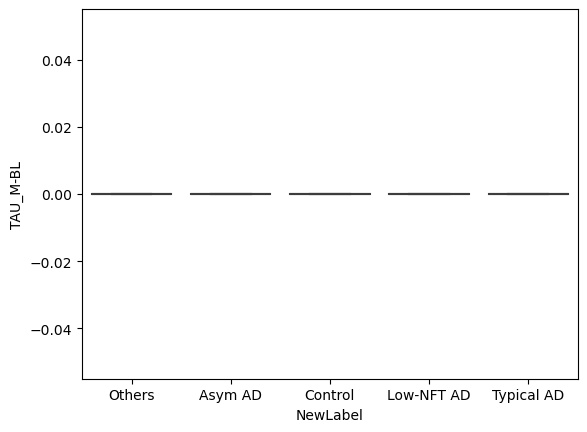

In [511]:
sns.boxplot(data=anndata_ADNI_obs_dropna, x='NewLabel', y='TAU_M-BL')

<Axes: xlabel='NewLabel', ylabel='AV45_BL'>

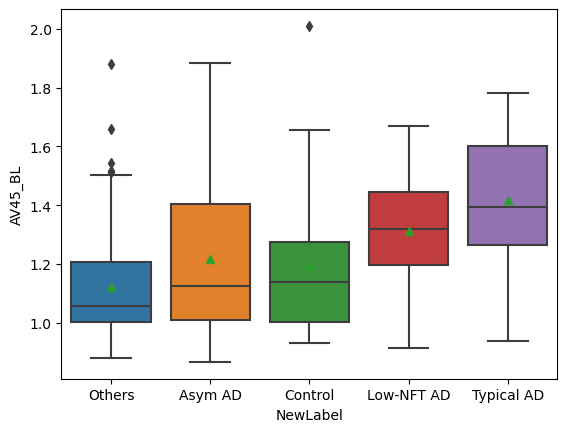

In [503]:
sns.boxplot(data=anndata_ADNI_obs_dropna, x='NewLabel', y='AV45_BL', showmeans=True)

<Axes: xlabel='NewLabel', ylabel='PTAU_BL'>

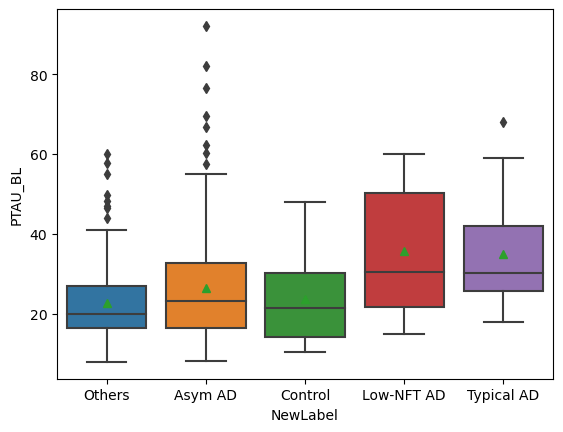

In [504]:
sns.boxplot(data=anndata_ADNI_obs_dropna, x='NewLabel', y='PTAU_BL', showmeans=True)

In [508]:
anndata_ADNI_Top.obs.to_csv("../../../Data/ADNI_NewModel_NewLabel_Clinical_Info.csv")

In [509]:
anndata_ADNI_Top.obs

,Label,Gender,Age,DX,Progressed,MMSE_Month,MMSE_Close,MMSE_BL,CDRSB_BL,PTAU_Close,...,TAU_Month,AV45_Month,PTAU_BL,TAU_BL,AV45_BL,CDRSB_Month,first_changing_time,n_counts_all,braaksc_trans,NewLabel
116_S_1249,Asym AD,Female,75,CN,Yes,30.0,30.0,30.0,0.0,inf,...,inf,inf,inf,inf,inf,0.0,35.836066,46323.804849,5.0,Others
037_S_4410,Asym AD,Female,69,CN,No,29.0,29.0,29.0,0.0,29.14,...,313.5,0.9862,29.14,313.5,0.9862,0.0,61.475410,46533.937284,4.0,Others
006_S_4153,Asym AD,Male,79,Dementia,No,22.0,22.0,22.0,3.0,42.01,...,405.9,1.2779,42.01,405.9,1.2779,3.0,30.000000,45881.501968,4.0,Asym AD
116_S_1232,Typical AD,Female,76,CN,No,27.0,27.0,28.0,0.0,inf,...,inf,1.2821,inf,inf,inf,0.0,36.295082,45672.591813,4.0,Others
099_S_4205,Asym AD,Female,81,MCI,No,29.0,29.0,29.0,0.5,27.46,...,281.8,1.3392,27.46,281.8,1.3392,0.5,61.016393,46196.449643,5.0,Asym AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
009_S_2381,Typical AD,Male,69,MCI,Yes,28.0,28.0,28.0,2.5,57.70,...,576.9,1.3430,57.70,576.9,1.3430,2.5,24.360656,45503.398576,1.0,Others
053_S_4557,Typical AD,Female,83,MCI,No,27.0,27.0,27.0,2.5,26.26,...,285.2,1.3257,26.26,285.2,1.3257,2.5,59.868852,46025.165544,5.0,Asym AD
073_S_4300,Asym AD,Female,81,MCI,No,26.0,26.0,26.0,1.5,14.10,...,166.1,0.9873,14.10,166.1,0.9873,1.5,35.803279,46121.202942,4.0,Asym AD
041_S_4014,Asym AD,Male,81,CN,No,29.0,29.0,29.0,0.0,30.92,...,313.2,1.6553,30.92,313.2,1.6553,0.0,47.344262,45695.602901,1.0,Control


In [755]:
df = anndata_ADNI_Top.obs[anndata_ADNI_Top.obs.NewLabel!='Others']
SID_ = list(df.index)

In [756]:
anndata_ADNI_Top = anndata_ADNI_Top[SID_,:]

In [757]:
sc.tl.pca(anndata_ADNI_Top, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ADNI_Top, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ADNI_Top)

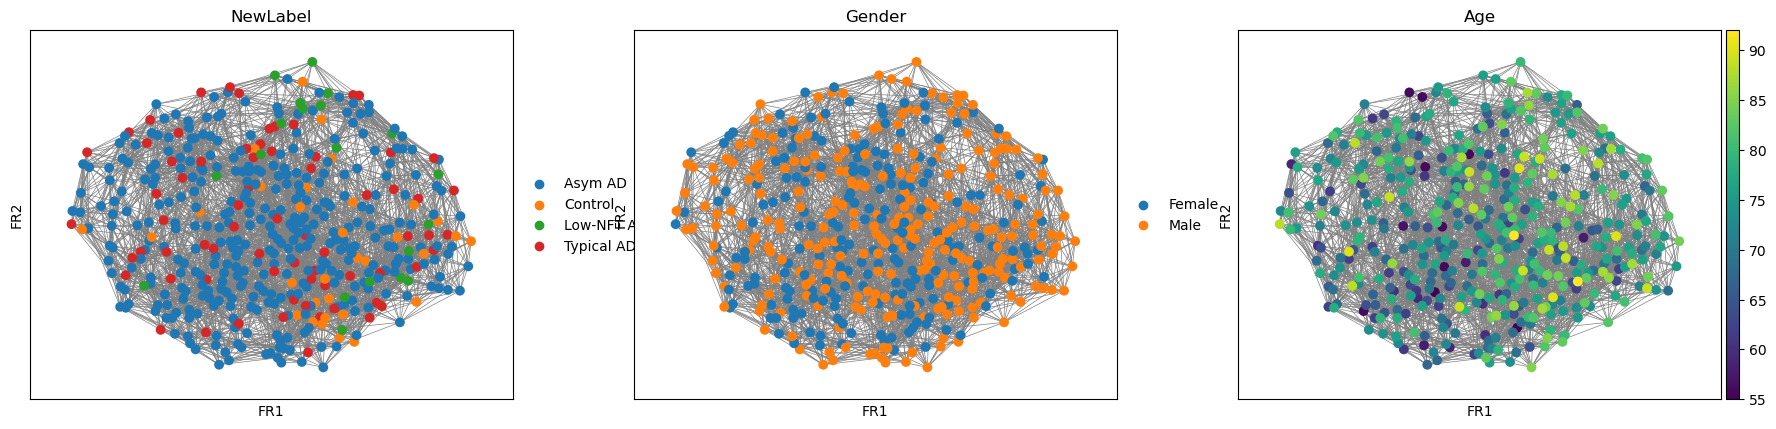

In [758]:
sc.pl.draw_graph(anndata_ADNI_Top, color=['NewLabel','Gender','Age'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 


In [759]:
sc.tl.pca(anndata_ADNI, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(anndata_ADNI, n_neighbors=15, n_pcs=50)  ## avoid clustering
sc.tl.draw_graph(anndata_ADNI)

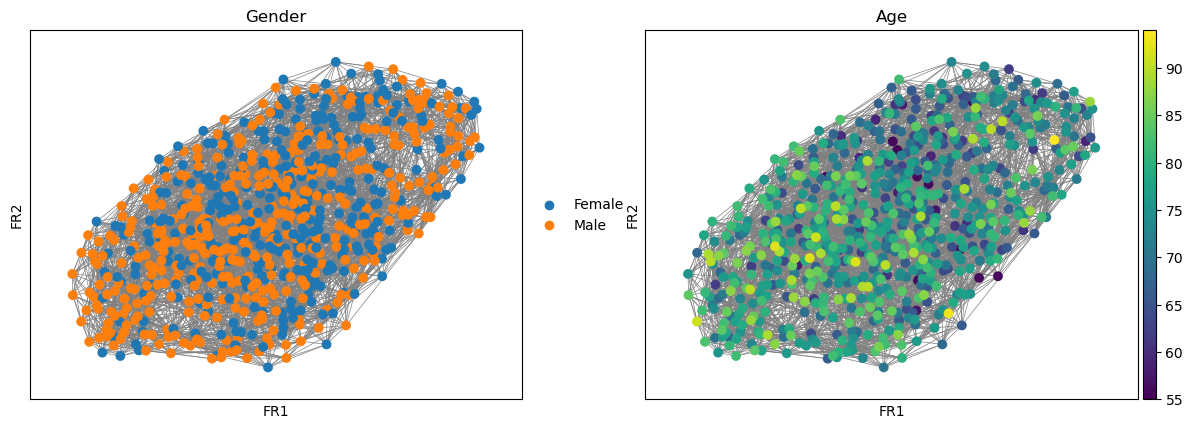

In [760]:
sc.pl.draw_graph(anndata_ADNI, color=['Gender','Age'], legend_loc='right margin', size=200, edges=True, edges_width=0.5) 
